In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import re
import h5py
from six.moves import range

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline

In [2]:
import sys
sys.path.append('/Users/perdue/Documents/MINERvA/AI/ANNMINERvA/mnvtf')
print(sys.path)

from reader_sqlite import MnvCategoricalSQLiteReader

['', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python27.zip', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/plat-darwin', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/plat-mac', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/lib-tk', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/lib-old', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/lib-dynload', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/cycler-0.10.0-py2.7.egg', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/mccabe-0.6.1-py2.7.egg', '/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/IPython/extensions', '/Users/perdue/.ipython', '/Users/perdue/Documents/MINERvA/AI/ANNMINERvA/mnvtf']


In [3]:
def make_plots_raw(arr, plot_type, colormap='Reds'):
    """
    plots and text for confusion matrices
    """
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(1, 2)

    def make_title_string(title, logscale):
        title = r'Log$_{10}$ ' + title if logscale else title
        return title
    
    def make_subplot(ax, show_arr, colormap, title):
        im = ax.imshow(show_arr, cmap=plt.get_cmap(colormap), interpolation='nearest', origin='lower')
        cbar = plt.colorbar(im, fraction=0.04)
        plt.title(title)
        plt.xlabel('Softmax probabilties')
        plt.ylabel('Predicted segment')
        
    # linear plots
    ax = plt.subplot(gs[0])
    show_arr = arr
    make_subplot(ax, show_arr, colormap, make_title_string('Probabilities', False))

    # log plots
    ax = plt.subplot(gs[1])
    show_arr = np.log10(arr * 100.0)
    make_subplot(ax, show_arr, colormap, make_title_string('Probabilities', True))
    
    fig.savefig('reco_probabilities_{}.pdf'.format(plot_type), bbox_inches='tight')

In [4]:
def make_diff_plots_raw(arr1, arr2, plot_type, colormap='Reds'):
    """
    plots and text for confusion matrices
    """
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(1, 2)
    arr = arr1 - arr2

    def make_title_string(title, logscale):
        title = r'Log$_{10}$ ' + title if logscale else title
        return title
    
    def make_subplot(ax, show_arr, colormap, title):
        im = ax.imshow(show_arr, cmap=plt.get_cmap(colormap), interpolation='nearest', origin='lower')
        cbar = plt.colorbar(im, fraction=0.04)
        plt.title(title)
        plt.xlabel('True z-segment')
        plt.ylabel('Reconstructed z-segment')
        
    # linear plots
    ax = plt.subplot(gs[0])
    show_arr = arr
    make_subplot(ax, show_arr, colormap, make_title_string('Differences', False))
    
    #print(np.sum(arr, axis=0))
    
    fig.savefig('differences_raw_{}.pdf'.format(plot_type), bbox_inches='tight')

In [5]:
def make_single_scatters_by_target(arr, plot_type, n_classes=173):
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(2, 4)
    
    idcs = np.arange(n_classes)    
    ids = zip(range(7), [0, 9, 18, 27, 44, 49, 66])
    
    for id in ids:
        ax = plt.subplot(gs[id[0]])
        tmparr = arr[:,id[1]]
        tmparr = tmparr / np.max(tmparr)
        plt.scatter(idcs, tmparr)
        #plt.ylim([-0.001, 0.009])
        
    fig.savefig('single_scatters_by_target_raw_{}.pdf'.format(plot_type), bbox_inches='tight')

In [6]:
def make_scatters_by_target_ratio(arr1, arr2, plot_type, n_classes=173):
    idcs = np.arange(n_classes)
    ids = zip(range(7), [0, 9, 18, 27, 44, 49, n_classes-1])
    titles = ['upstream', 'target 1', 'target 2', 'target 3', 'target 4', 'target 5', 'upstream']
    
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(2, 4)    
    for id in ids:
        ax = plt.subplot(gs[id[0]])
        tmparr1 = arr1[:,id[1]]
        #tmparr1 = tmparr1 / np.max(tmparr1)
        tmparr2 = arr2[:,id[1]]
        #tmparr2 = tmparr2 / np.max(tmparr2)
        tmparr = tmparr1 / tmparr2
        plt.scatter(idcs, tmparr)
        plt.title(titles[id[0]])
        plt.xlabel('plane')
        plt.ylabel('softmax ratio (data/mc)')
        #plt.ylim([-0.001, 0.009])
    
    fig.savefig('single_scatters_by_target_ratio_raw_{}.pdf'.format(plot_type), bbox_inches='tight')

In [7]:
def make_scatters_by_target_same(arr1, arr2, plot_type, label1='MC', label2='Data', n_classes=173):
    idcs = np.arange(n_classes)
    ids = zip(range(7), [0, 9, 18, 27, 44, 49, n_classes-1])
    titles = ['upstream', 'target 1', 'target 2', 'target 3', 'target 4', 'target 5', 'upstream']
    leg_locs = [1] * 6 + [2]
            
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(2, 4)        
    for id in ids:
        ax = plt.subplot(gs[id[0]])
        tmparr1 = arr1[:,id[1]]
        tmparr2 = arr2[:,id[1]]
        plt.scatter(idcs, tmparr1, c='g', label=label1)
        plt.scatter(idcs, tmparr2, c='r', label=label2)
        plt.title(titles[id[0]])
        plt.xlabel('plane')
        plt.ylabel('softmax value')        
        plt.ylim([0.0, 1.0])
        plt.legend(loc=leg_locs[id[0]])
        
    fig.savefig('single_scatters_by_target_same_raw_{}.pdf'.format(plot_type), bbox_inches='tight')

In [8]:
DBDIR = '/Users/perdue/Documents/MINERvA/AI/prediction_dbs/theano/predictions'
MCDB = DBDIR + '/' + 'prediction67_me1Amc_epsilon1480703388'
DATADB = DBDIR + '/' + 'prediction67_me1Adata_epsilon1480703388'

DBDIR = '/Users/perdue/Documents/MINERvA/AI/prediction_dbs/caffe/aghosh'
MCDB = DBDIR + '/' + 'DANN_me1Btrain_me1Amcpred_text'
DATADB = DBDIR + '/' + 'DANN_me1Btrain_me1Adatapred'
PLOT_TYPE = 'DANN'

DBDIR = '/Users/perdue/Documents/MINERvA/AI/prediction_dbs/tensorflow/201801'

MCDB = DBDIR + '/' + 'mnv_st_epsilon_predictionsME1AMCNX_model_20180202_planecodes_nclass173_trainME1ABGMCEROICAPLUS_validME1ABGMCEROICAPLUS_testME1AMCNX_optADAM_batchsz1024_nodoBatchNorm_tev'
DATADB = DBDIR + '/' + 'mnv_st_epsilon_predictionsME1ADATANX_model_20180202_planecodes_nclass173_trainME1ABGMCEROICAPLUS_validME1ABGMCEROICAPLUS_testME1AMCNX_optADAM_batchsz1024_nodoBatchNorm_tev'
PLOT_TYPE = 'DCNN'


In [9]:
n_classes = 173

In [10]:
reader_mc = MnvCategoricalSQLiteReader(n_classes, MCDB)     # need 'prob%02d' for old theano dbs
reader_data = MnvCategoricalSQLiteReader(n_classes, DATADB)

In [11]:
results = reader_mc.read_record_by_id(1)
print(results)
rn = results[0][1]
sb = results[0][2]
gt = results[0][3]
pe = results[0][4]

[(1, 110018, 121, 247, 1, 98, 5.81483874384503e-08, 1.8378795152429461e-09, 2.2733339655189866e-09, 1.1316715342601924e-09, 2.016145472794051e-09, 4.207702186675988e-09, 4.6580881374325145e-09, 9.975643422421854e-09, 5.382656986796519e-09, 6.456441603575058e-09, 3.5513916807339285e-10, 5.518662193892965e-10, 9.066742912011705e-09, 7.209900587668017e-08, 6.2215708140911374e-09, 3.061505893242611e-08, 5.7862585833845515e-09, 1.0488277801812274e-08, 4.4818385447342735e-08, 3.977609353000844e-08, 4.5837222018008106e-08, 5.227252231065904e-08, 4.6923148033783946e-08, 2.9993587613574846e-09, 5.343152587045097e-09, 2.500783224945735e-08, 4.743191084344289e-08, 1.5568559774692403e-07, 9.013772839239209e-09, 9.553875912615695e-09, 3.836831297121535e-09, 1.7654362416408276e-09, 2.320878822459349e-09, 1.8060654083384975e-09, 2.959268829982875e-09, 1.8210535301932396e-09, 1.9246204630007924e-08, 5.625332644143555e-09, 4.380539309067899e-08, 3.224325695327934e-08, 3.93689436606337e-09, 7.3915531473

In [12]:
reader_mc.get_argmax_prediction(rn, sb, gt, pe)

98

In [13]:
#%debug

In [14]:
reader_mc.read_record(rn, sb, gt, pe)

[(1, 110018, 121, 247, 1, 98, 5.81483874384503e-08, 1.8378795152429461e-09, 2.2733339655189866e-09, 1.1316715342601924e-09, 2.016145472794051e-09, 4.207702186675988e-09, 4.6580881374325145e-09, 9.975643422421854e-09, 5.382656986796519e-09, 6.456441603575058e-09, 3.5513916807339285e-10, 5.518662193892965e-10, 9.066742912011705e-09, 7.209900587668017e-08, 6.2215708140911374e-09, 3.061505893242611e-08, 5.7862585833845515e-09, 1.0488277801812274e-08, 4.4818385447342735e-08, 3.977609353000844e-08, 4.5837222018008106e-08, 5.227252231065904e-08, 4.6923148033783946e-08, 2.9993587613574846e-09, 5.343152587045097e-09, 2.500783224945735e-08, 4.743191084344289e-08, 1.5568559774692403e-07, 9.013772839239209e-09, 9.553875912615695e-09, 3.836831297121535e-09, 1.7654362416408276e-09, 2.320878822459349e-09, 1.8060654083384975e-09, 2.959268829982875e-09, 1.8210535301932396e-09, 1.9246204630007924e-08, 5.625332644143555e-09, 4.380539309067899e-08, 3.224325695327934e-08, 3.93689436606337e-09, 7.3915531473

In [15]:
reader_data.read_record_by_id(1)

[(1, 10051, 45, 549, 17, 87, 7.926475518615916e-06, 2.1278669493085545e-08, 4.6297191858002407e-08, 2.769318463435866e-08, 3.703248907527268e-08, 3.816017724034282e-08, 3.878145449220938e-08, 3.737045162210961e-08, 3.072062213504978e-07, 9.089026207220741e-07, 1.1540456057446136e-07, 1.0645333503589427e-07, 7.465119011840216e-08, 1.542315857250287e-07, 7.08082623646078e-08, 5.663661539756504e-08, 1.0295778452018567e-08, 9.158006797349572e-09, 2.945298263057339e-07, 6.065918682907068e-07, 9.658849364768685e-08, 6.412932851418418e-09, 2.033234558496133e-08, 1.1664130994404331e-08, 2.7757738330080883e-09, 4.179163681783393e-09, 2.986157099371667e-08, 1.700414031802211e-07, 4.7290467364291544e-07, 7.032228950265562e-07, 5.528451652025979e-07, 2.4127327833411982e-06, 8.461108791379957e-07, 1.0744061285095086e-07, 1.3133892196037777e-07, 4.432276767829535e-08, 8.021523711931877e-08, 9.36550463848107e-07, 2.30014779845078e-06, 8.42097961140098e-07, 2.609456828395196e-07, 4.8161577836935976e-0

In [16]:
reader_mc.read_record_by_id(1)[0][0:6]

(1, 110018, 121, 247, 1, 98)

In [17]:
n_classes = len(reader_mc.read_record_by_id(1)[0][6:])
print(n_classes)

173


In [18]:
np.sum(reader_mc.read_record_by_id(1)[0][6:])

1.0000001989772185

```
aghosh$ sqlite3 DANN_me1Btrain_me1Adatapred.db
SQLite version 3.16.0 2016-11-04 19:09:39
Enter ".help" for usage hints.
sqlite> select max(id) from zsegment_prediction;
960800
sqlite> .q
aghosh$ sqlite3 DANN_me1Btrain_me1Amcpred_text.db
SQLite version 3.16.0 2016-11-04 19:09:39
Enter ".help" for usage hints.
sqlite> select max(id) from zsegment_prediction;
6661200
sqlite> .q
```

In [19]:
n_evt = 5000
#n_evt = 500000

/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide
/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in divide


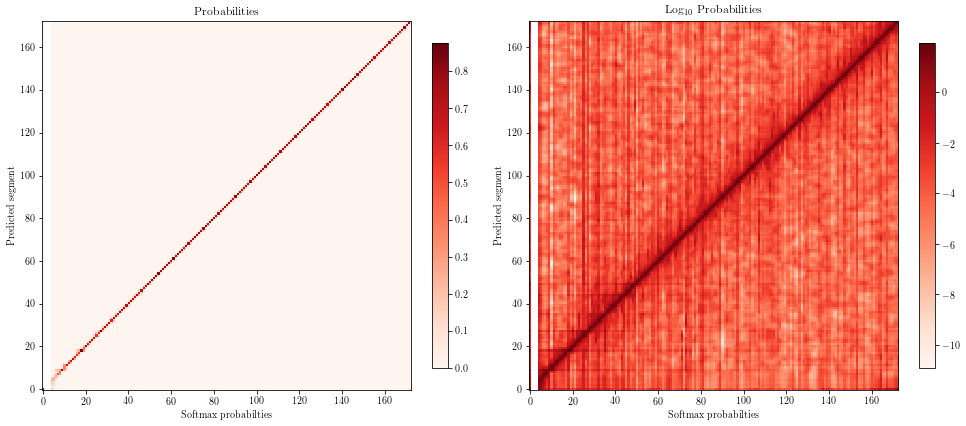

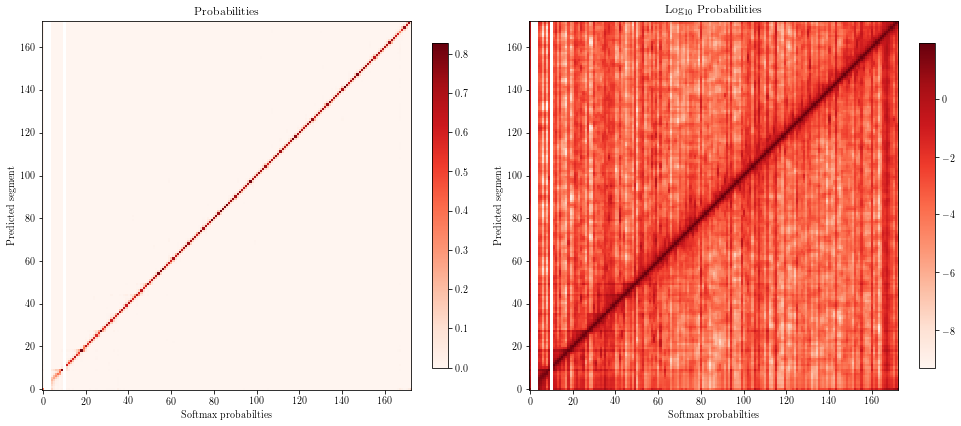

In [20]:
results_mc = np.zeros((n_classes, n_classes))

# theano...
#sqlite> select count(*) from zsegment_prediction;
#6661231
#sqlite> select max(id) from zsegment_prediction;
#6661231

for i in range(n_evt):
    id = i + 1
    if id % 20000 == 0:
        print(id, '/', n_evt)
    fetched = reader_mc.read_record_by_id(id)[0]
    segment = fetched[5]
    results_mc[:,segment] += fetched[6:]
    
n_pred_mc = np.zeros(n_classes)
for i in range(n_classes):
    s = np.sum(results_mc[:,i])
    n_pred_mc[i] = s
    results_mc[:,i] = results_mc[:,i] / s

make_plots_raw(results_mc, 'mc')

results_data = np.zeros((n_classes, n_classes))

# theano...
#sqlite> select max(id) from zsegment_prediction;
#957109

for i in range(n_evt):
    id = i + 1
    if id % 20000 == 0:
        print(id, '/', n_evt)
    fetched = reader_data.read_record_by_id(id)[0]
    segment = fetched[5]
    results_data[:,segment] += fetched[6:]
    
n_pred_data = np.zeros(n_classes)
for i in range(n_classes):
    s = np.sum(results_data[:,i])
    n_pred_data[i] = s
    results_data[:,i] = results_data[:,i] / s

make_plots_raw(results_data, 'data')

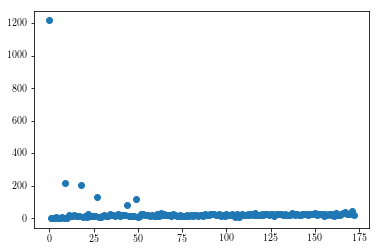

In [21]:
plt.scatter(np.arange(n_classes), n_pred_data)

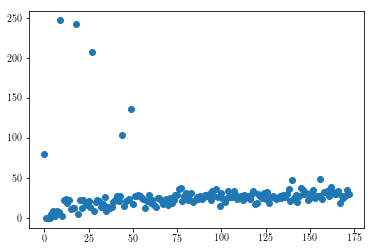

In [22]:
plt.scatter(np.arange(n_classes), n_pred_mc)

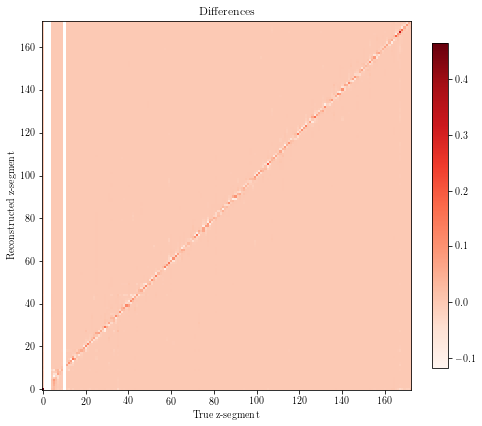

In [23]:
make_diff_plots_raw(results_mc, results_data, 'mc_minus_data')

Max probability normalized vectors for the events that had the targets as their max softmax value for MC:

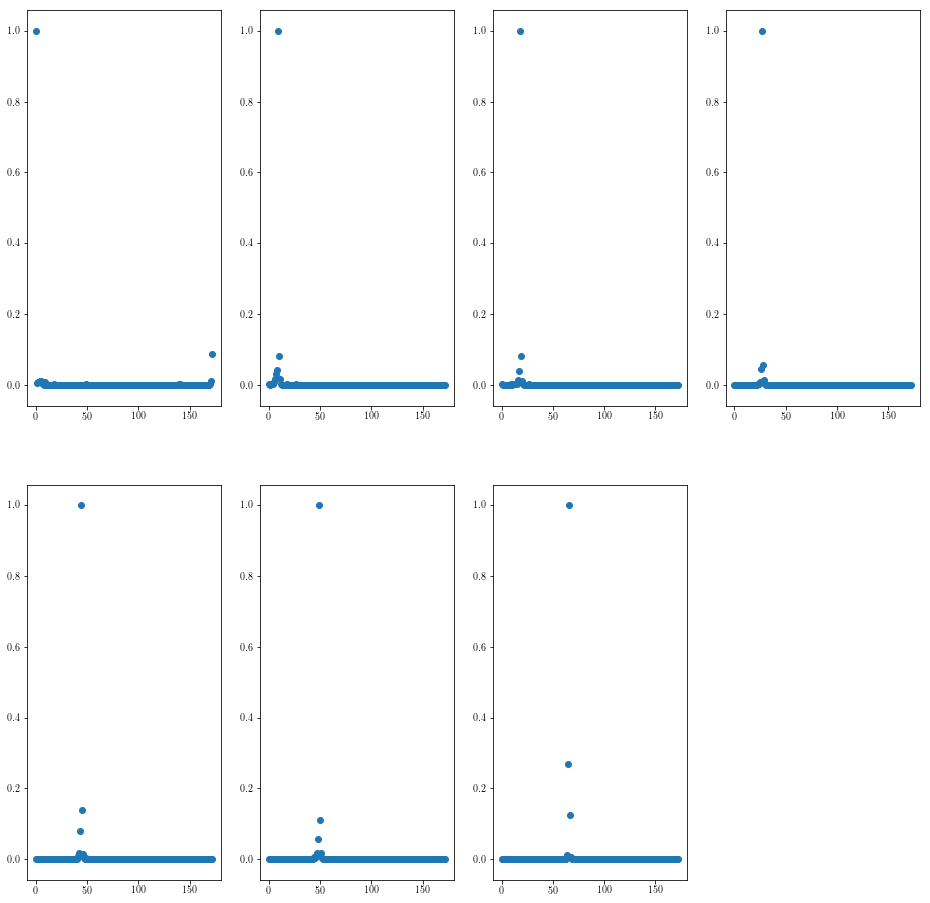

In [24]:
make_single_scatters_by_target(results_mc, 'mc')

Max probability normalized vectors for the events that had the targets as their max softmax value for data:

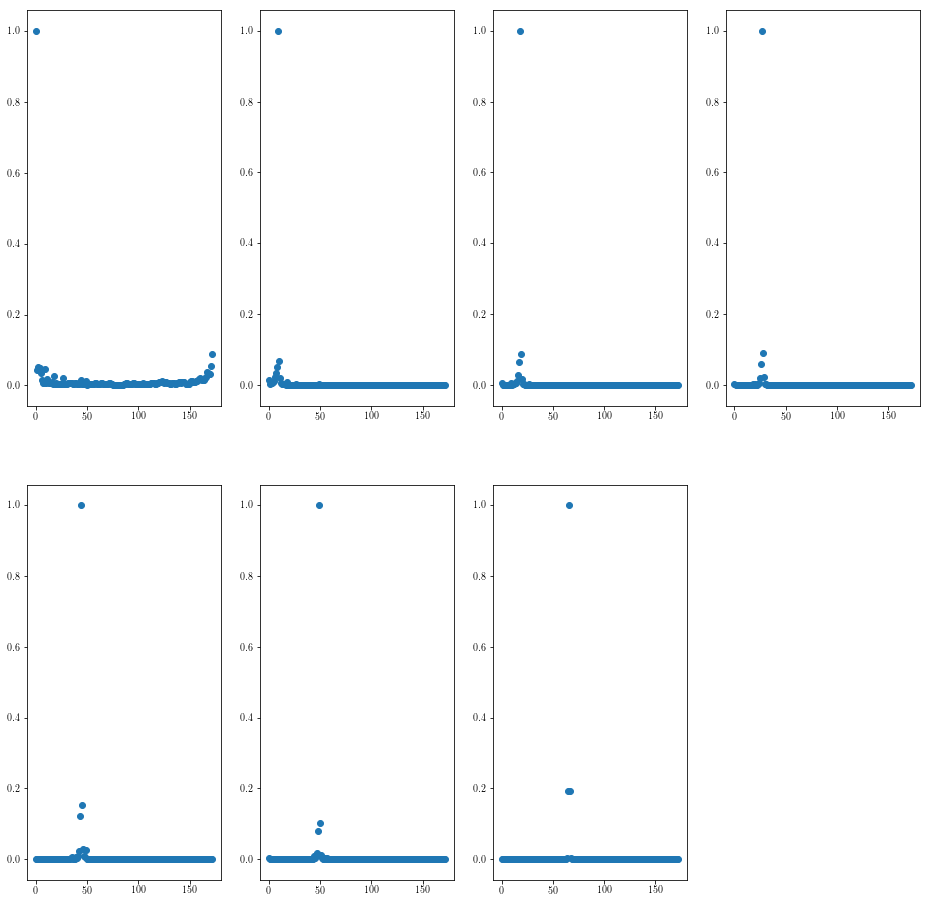

In [25]:
make_single_scatters_by_target(results_data, 'data')

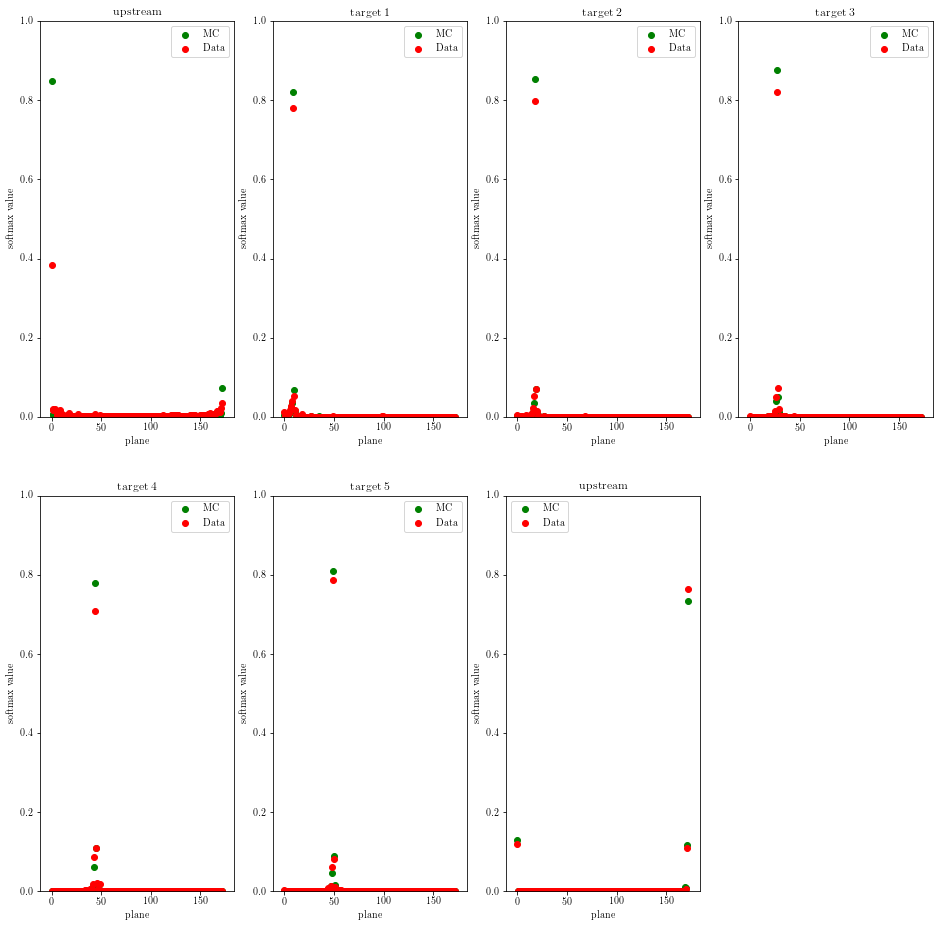

In [26]:
make_scatters_by_target_same(results_mc, results_data, PLOT_TYPE)

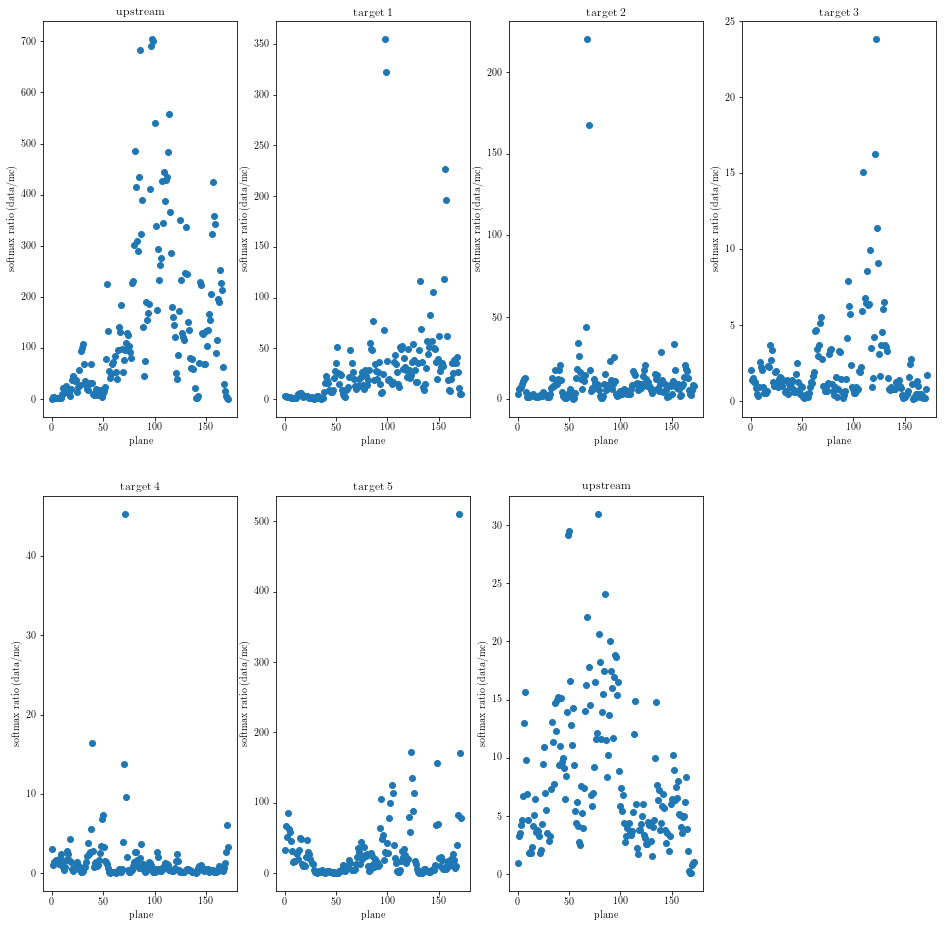

In [27]:
make_scatters_by_target_ratio(results_data, results_mc, PLOT_TYPE)

In [27]:
a = (results_mc - results_data)**2
a_s = np.sum(a, axis=0)
print(a_s)

[  6.23315088e-03   9.52252310e-04              nan   1.35950543e-03
   1.45894399e-04   8.67815453e-04   3.51390708e-04   1.46372843e-04
   4.23841497e-04   2.33220730e-03              nan   1.25770396e-04
   5.21782283e-04   6.41734333e-04   7.63194759e-04   4.61720933e-04
   4.18137007e-04   1.52232808e-04   1.16899189e-03   9.66100479e-04
   3.20987961e-04   3.66602620e-04   3.04511309e-04   8.24775303e-04
   1.77252136e-04   5.21086539e-04   1.54708411e-04   1.00465727e-03
   1.55278540e-04   4.76067623e-04   4.19428321e-04   9.74796710e-04
   3.14227138e-04   4.18155034e-04   7.90647456e-04   4.10187777e-04
   7.01254042e-04   2.50009568e-04   3.44666035e-04   5.52427818e-04
   3.41360413e-04   7.96057450e-04   9.37863788e-04   4.43729564e-04
   1.23573799e-03   1.94816330e-04   1.17592241e-04   1.37877237e-04
   1.55624961e-04   2.36291856e-04   1.57181055e-04   5.54608656e-05
   2.70967537e-04   1.52983517e-04   2.31422592e-04   1.57605812e-04
   6.57697455e-05   2.40630857e-04

In [28]:
a_s = a_s / (1/n_pred_mc + 1/n_pred_data)
a_s_real = a_s[~np.isnan(a_s)]
print(a_s_real)
print(np.sum(a_s_real))

[  2.67222548e+00   1.63243251e-03   3.02112331e-03   5.23300185e-03
   4.59621276e-01   7.51800654e-02   8.27510119e-02   5.37399061e-03
   2.69363876e+01   6.52336316e-02   4.16584286e-01   4.29725560e-01
   5.85833904e-01   2.88881712e-01   2.36145963e-01   3.81058339e-02
   1.35594624e+01   3.10532325e-03   2.17911030e-01   3.51006405e-01
   1.91730629e-01   6.86056822e-01   1.26437641e-01   4.18221492e-01
   7.54054851e-02   8.31636587e+00   2.97803338e-02   4.09824979e-01
   3.21758430e-01   7.88553266e-01   2.70880669e-01   3.41522194e-01
   3.71801973e-01   4.98226313e-01   6.45900904e-01   2.41387142e-01
   2.86911480e-01   4.92101056e-01   3.09530700e-01   6.59909662e-01
   6.56367252e-01   2.71637360e-01   6.91567495e+00   3.16136088e-02
   1.02549380e-01   9.49286964e-02   8.33938189e-02   1.70804584e+00
   8.14124769e-03   5.54901273e-02   2.56613864e-01   1.22826219e-01
   2.07361355e-01   1.58734622e-01   6.97241478e-02   1.91697830e-01
   1.36104929e-01   1.74041284e-01

/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.


In [29]:
np.sum(results_mc[:,9])

0.99999999999999989

In [30]:
np.sum(results_data[:,9])

1.0